<a href="https://colab.research.google.com/github/ntontonto/kaggle/blob/mitty_branch/Sprint7_selectKbest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle用データのインポート

In [1]:
from google.colab import drive
drive.mount('/content/drive')

COMPETITION = "house-prices-advanced-regression-techniques"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/kaggle"

import os

if not(os.path.exists(WORK_DIR)):
  os.mkdir(WORK_DIR)
os.chdir(WORK_DIR)

from google.colab import files
files.upload()

Mounted at /content/drive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rmkenshirou","key":"e460ce0d323c2eed67441cce23eb3978"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c {COMPETITION} # copy from competition page!
!unzip {COMPETITION}
!rm {COMPETITION}.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 19.9MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## ライブラリのインポート

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.stats import power
import statsmodels.api as sm
from scipy import stats
import math
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE) # seabornのデフォルトの色を変更する
BACKCOLOR = '#f6f5f5'

from IPython.core.display import HTML

## 前準備

### User modules

In [ ]:
# 並び替え検定用の関数
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

In [ ]:
# permutation test
def permutation_test(data, var, target):

  vA = data[var].dropna().unique()[0]
  vB = data[var].dropna().unique()[1]
  mean_a = data[data[var] == vA][target].mean()
  mean_b = data[data[var] == vB][target].mean()
  print(f"{target} mean value with {var}={vA}: {mean_a}")
  print(f"{target} mean value with {var}={vB}: {mean_b}")
  print(f"{target} observed difference between ({var}={vA}) and ({var}={vB}): {mean_b - mean_a}")
  nA = data[data[var] == vA].shape[0]
  nB = data[data[var] == vB].shape[0]

  random.seed(1)
  perm_diffs = pd.Series([perm_fun(data[target], nA, nB) for _ in range(1000)])
  perm_diffs = perm_diffs.dropna()

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.hist(perm_diffs, bins=11, rwidth=0.9)
  ax.axvline(x = mean_b - mean_a, color='black', lw=2)
  ax.text(mean_b - mean_a, 10, 'Observed\ndifference', bbox={'facecolor':'white'})
  ax.set_xlabel(f'{var} differences')
  ax.set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

  perm_diffs = np.array(perm_diffs)
  print('p-value: ', (np.mean(perm_diffs > mean_b - mean_a)))

In [ ]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [ ]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=1, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=13)
        ax[i].set_ylabel('Count', weight='bold', size=13)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    plt.show()

In [ ]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=train, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

In [ ]:
# ANOVA using permutation test
# Image size が ～～～ のエラーが出た場合は logx = True に設定する
def anova_perm(data, var, target, logx=False):

  # Creating crosstab
  crosstb = pd.crosstab(data[var], data[target])
  
  # Creating barplot
  # pl = crosstb.plot(kind="bar", stacked=True, rot=0)

  for col in data[var].unique():
      try:
          true_ratio = len(data[(data[var]==col)&(data[target]==True)]) / len(data[data[var]==col])
      except:
          break
      print(col, true_ratio)

  observed_variance = data.groupby(var).mean().var()[target] # グループごとの平均値を求め、その平均値の分散を計算している
  print('Observed means:', data.groupby(var).mean()[target].values.ravel()) # ravel: 横方向の1次元のベクトルを返す
  print('Variance:', observed_variance)
  # Permutation test example with stickiness
  def perm_test(data):
      data = data.copy()
      data[target] = np.random.permutation(data[target].values)
      return data.groupby(var).mean().var()[target]
    
  random.seed(1)
  perm_variance = [perm_test(data) for _ in range(3000)]
  print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

  if logx == True:
    # 横長のグラフになってしまうので自然対数を取った（通常は下記2行は不要）
    observed_variance_log = np.log(observed_variance)
    perm_variance_log = np.log(perm_variance)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance_log, bins=11, rwidth=0.9)

    # 横長のグラフになってしまうので自然対数を取った（通常はxにobserved_varianceを指定）
    ax.axvline(x = observed_variance_log, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
  else:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance, bins=11, rwidth=0.9)

    ax.axvline(x = observed_variance, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

## データのダウンロード

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

all_data = pd.concat([train, test], axis=0)

## Check data

In [ ]:
all_data.head(10).style.background_gradient() # 数字のデータに対して，値が大きいほど濃い色が塗られる？

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706.000000,Unf,0.000000,150.000000,856.000000,GasA,Ex,Y,SBrkr,856,854,0,1710,1.000000,0.000000,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2.000000,548.000000,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500.000000
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.000000,Unf,0.000000,284.000000,1262.000000,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.000000,1.000000,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2.000000,460.000000,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500.000000
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.000000,Unf,0.000000,434.000000,920.000000,GasA,Ex,Y,SBrkr,920,866,0,1786,1.000000,0.000000,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2.000000,608.000000,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500.000000
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216.000000,Unf,0.000000,540.000000,756.000000,GasA,Gd,Y,SBrkr,961,756,0,1717,1.000000,0.000000,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3.000000,642.000000,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000.000000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655.000000,Unf,0.000000,490.000000,1145.000000,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.000000,0.000000,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3.000000,836.000000,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000.000000
5,6,50,RL,85.000000,14115,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,Wood,Gd,TA,No,GLQ,732.000000,Unf,0.000000,64.000000,796.000000,GasA,Ex,Y,SBrkr,796,566,0,1362,1.000000,0.000000,1,1,1,1,TA,5,Typ,0,nan,Attchd,1993.000000,Unf,2.000000,480.000000,TA,TA,Y,40,30,0,320,0,0,nan,MnPrv,Shed,700,10,2009,WD,Normal,143000.000000
6,7,20,RL,75.000000,10084,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.000000,Gd,TA,PConc,Ex,TA,Av,GLQ,1369.000000,Unf,0.000000,317.000000,1686.000000,GasA,Ex,Y,SBrkr,1694,0,0,1694,1.000000,0.000000,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.000000,RFn,2.000000,636.000000,TA,TA,Y,255,57,0,0,0,0,nan,nan,nan,0,8,2007,WD,Normal,307000.000000
7,8,60,RL,nan,10382,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.000000,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.000000,BLQ,32.000000,216.000000,1107.000000,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.000000,0.000000,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.000000,

In [ ]:
print(f'\033[32mtrain size : {train.shape[0]} x {train.shape[1]}')
print(f'\033[32mtest size : {test.shape[0]} x {test.shape[1]}')
print(f'\033[32mtotal size : {all_data.shape[0]} x {all_data.shape[1]}')

train size : 1460 x 81
test size : 1459 x 80
total size : 2919 x 81


## カラムの説明
- （各カラムの情報を記載する。不要かも？）

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

### 欠損値の確認

In [ ]:
all_data.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 81, dtype: int64

### data_description.txt

In [ ]:
!cat data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## カテゴリ変数の定義

### 量的変数、カテゴリ変数の定義
自動で数的変数、カテゴリ変数、名義尺度 等を判別する

In [ ]:
all_data["Neighborhood"].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64

### 型の種類をまずは見てみる

In [ ]:
list(set(all_data.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]

In [ ]:
categorical_cols = []
numerical_cols = []
boolean_cols = []
nominal_cols = []
for col in train.columns:
  if train[col].dtype in ['float', "int"]:
    numerical_cols.append(col)
  else:
    if train[col].nunique() < 3: # len()だと長くなるのでnunique()に変更
      boolean_cols.append(col)
    elif train[col].nunique() < 20:
      categorical_cols.append(col) #カテゴリ変数
    else:
      nominal_cols.append(col) #量的変数

num_to_cat = ["MSSubClass"]
num_to_nominal = ["Id"]
for col in num_to_cat:
  categorical_cols.append(col)
  numerical_cols.remove(col)
for col in num_to_nominal:
  nominal_cols.append(col)
  numerical_cols.remove(col)
print('categorical_cols = ', categorical_cols)
print('numerical_cols = ', numerical_cols)
print('boolean_cols = ', boolean_cols)
print('nominal_cols = ', nominal_cols)

categorical_cols =  ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass']
numerical_cols =  ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', '

### 各カテゴリ変数のユニークな要素の個数

In [ ]:
multi_table([pd.DataFrame(all_data[i].value_counts()) for i in all_data.columns if i in categorical_cols])

,MSSubClass
20,1079
60,575
50,287
120,182
30,139
70,128
160,128
80,118
90,109
190,61


# データの概形確認

## 欠損値の確認

<Axes: >

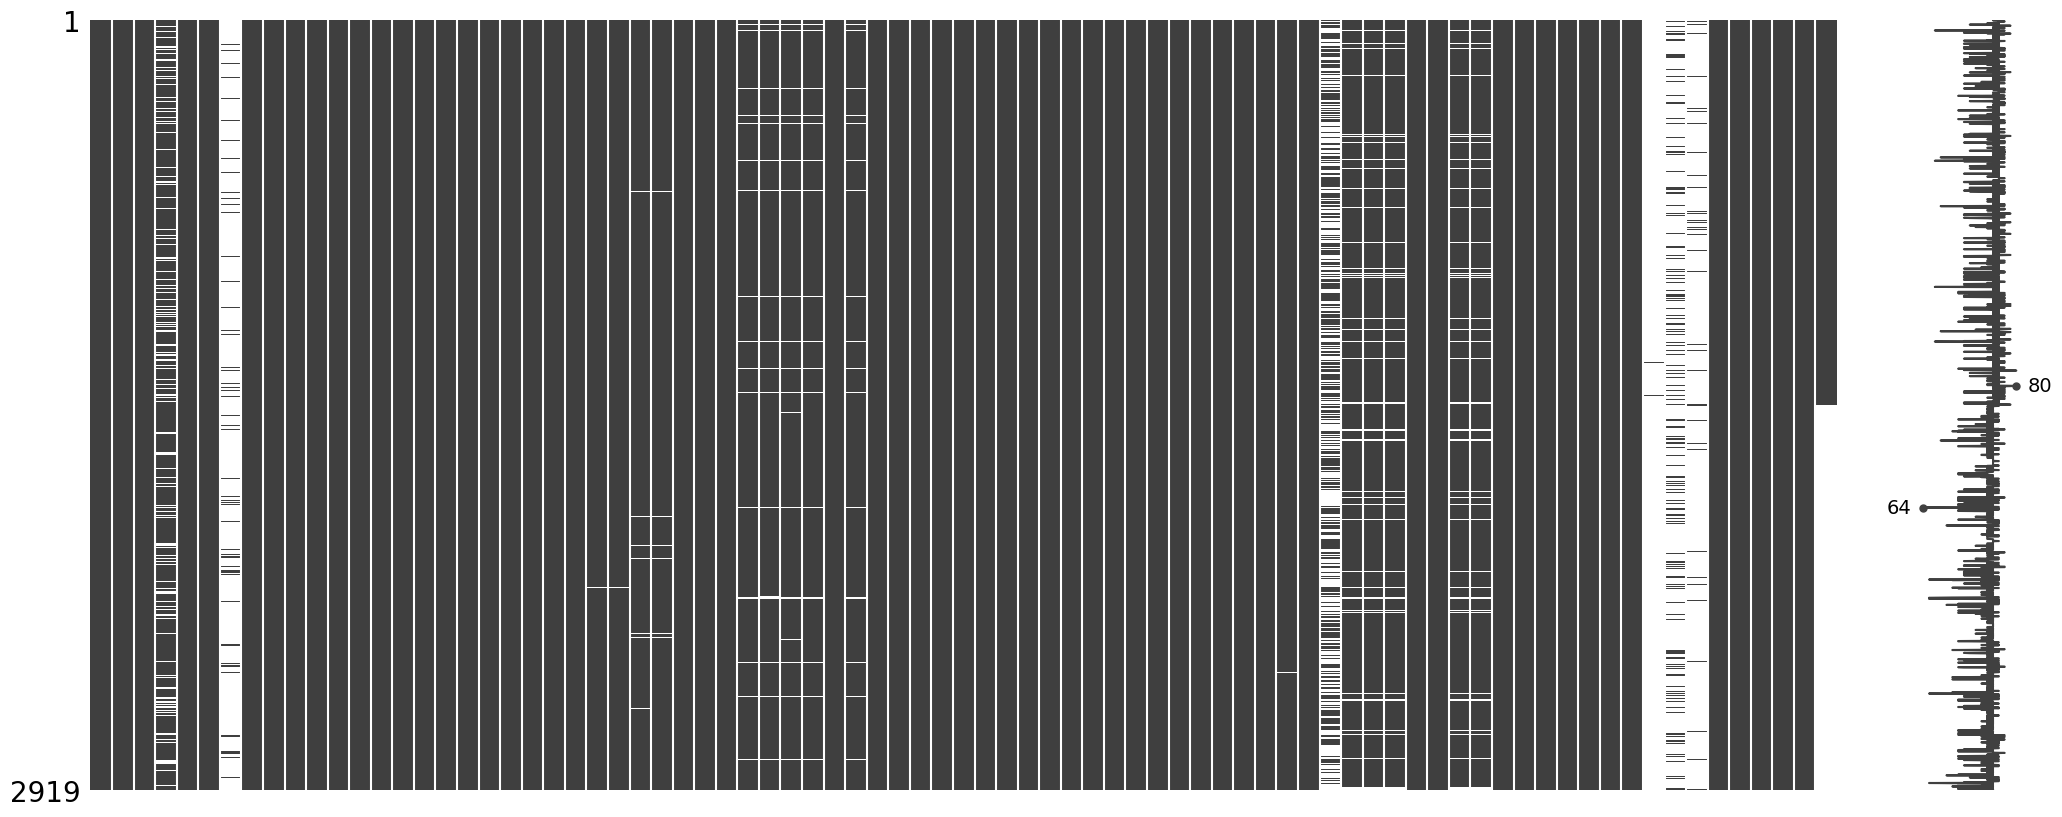

In [ ]:
import missingno as msno
msno.matrix(all_data)

<Axes: >

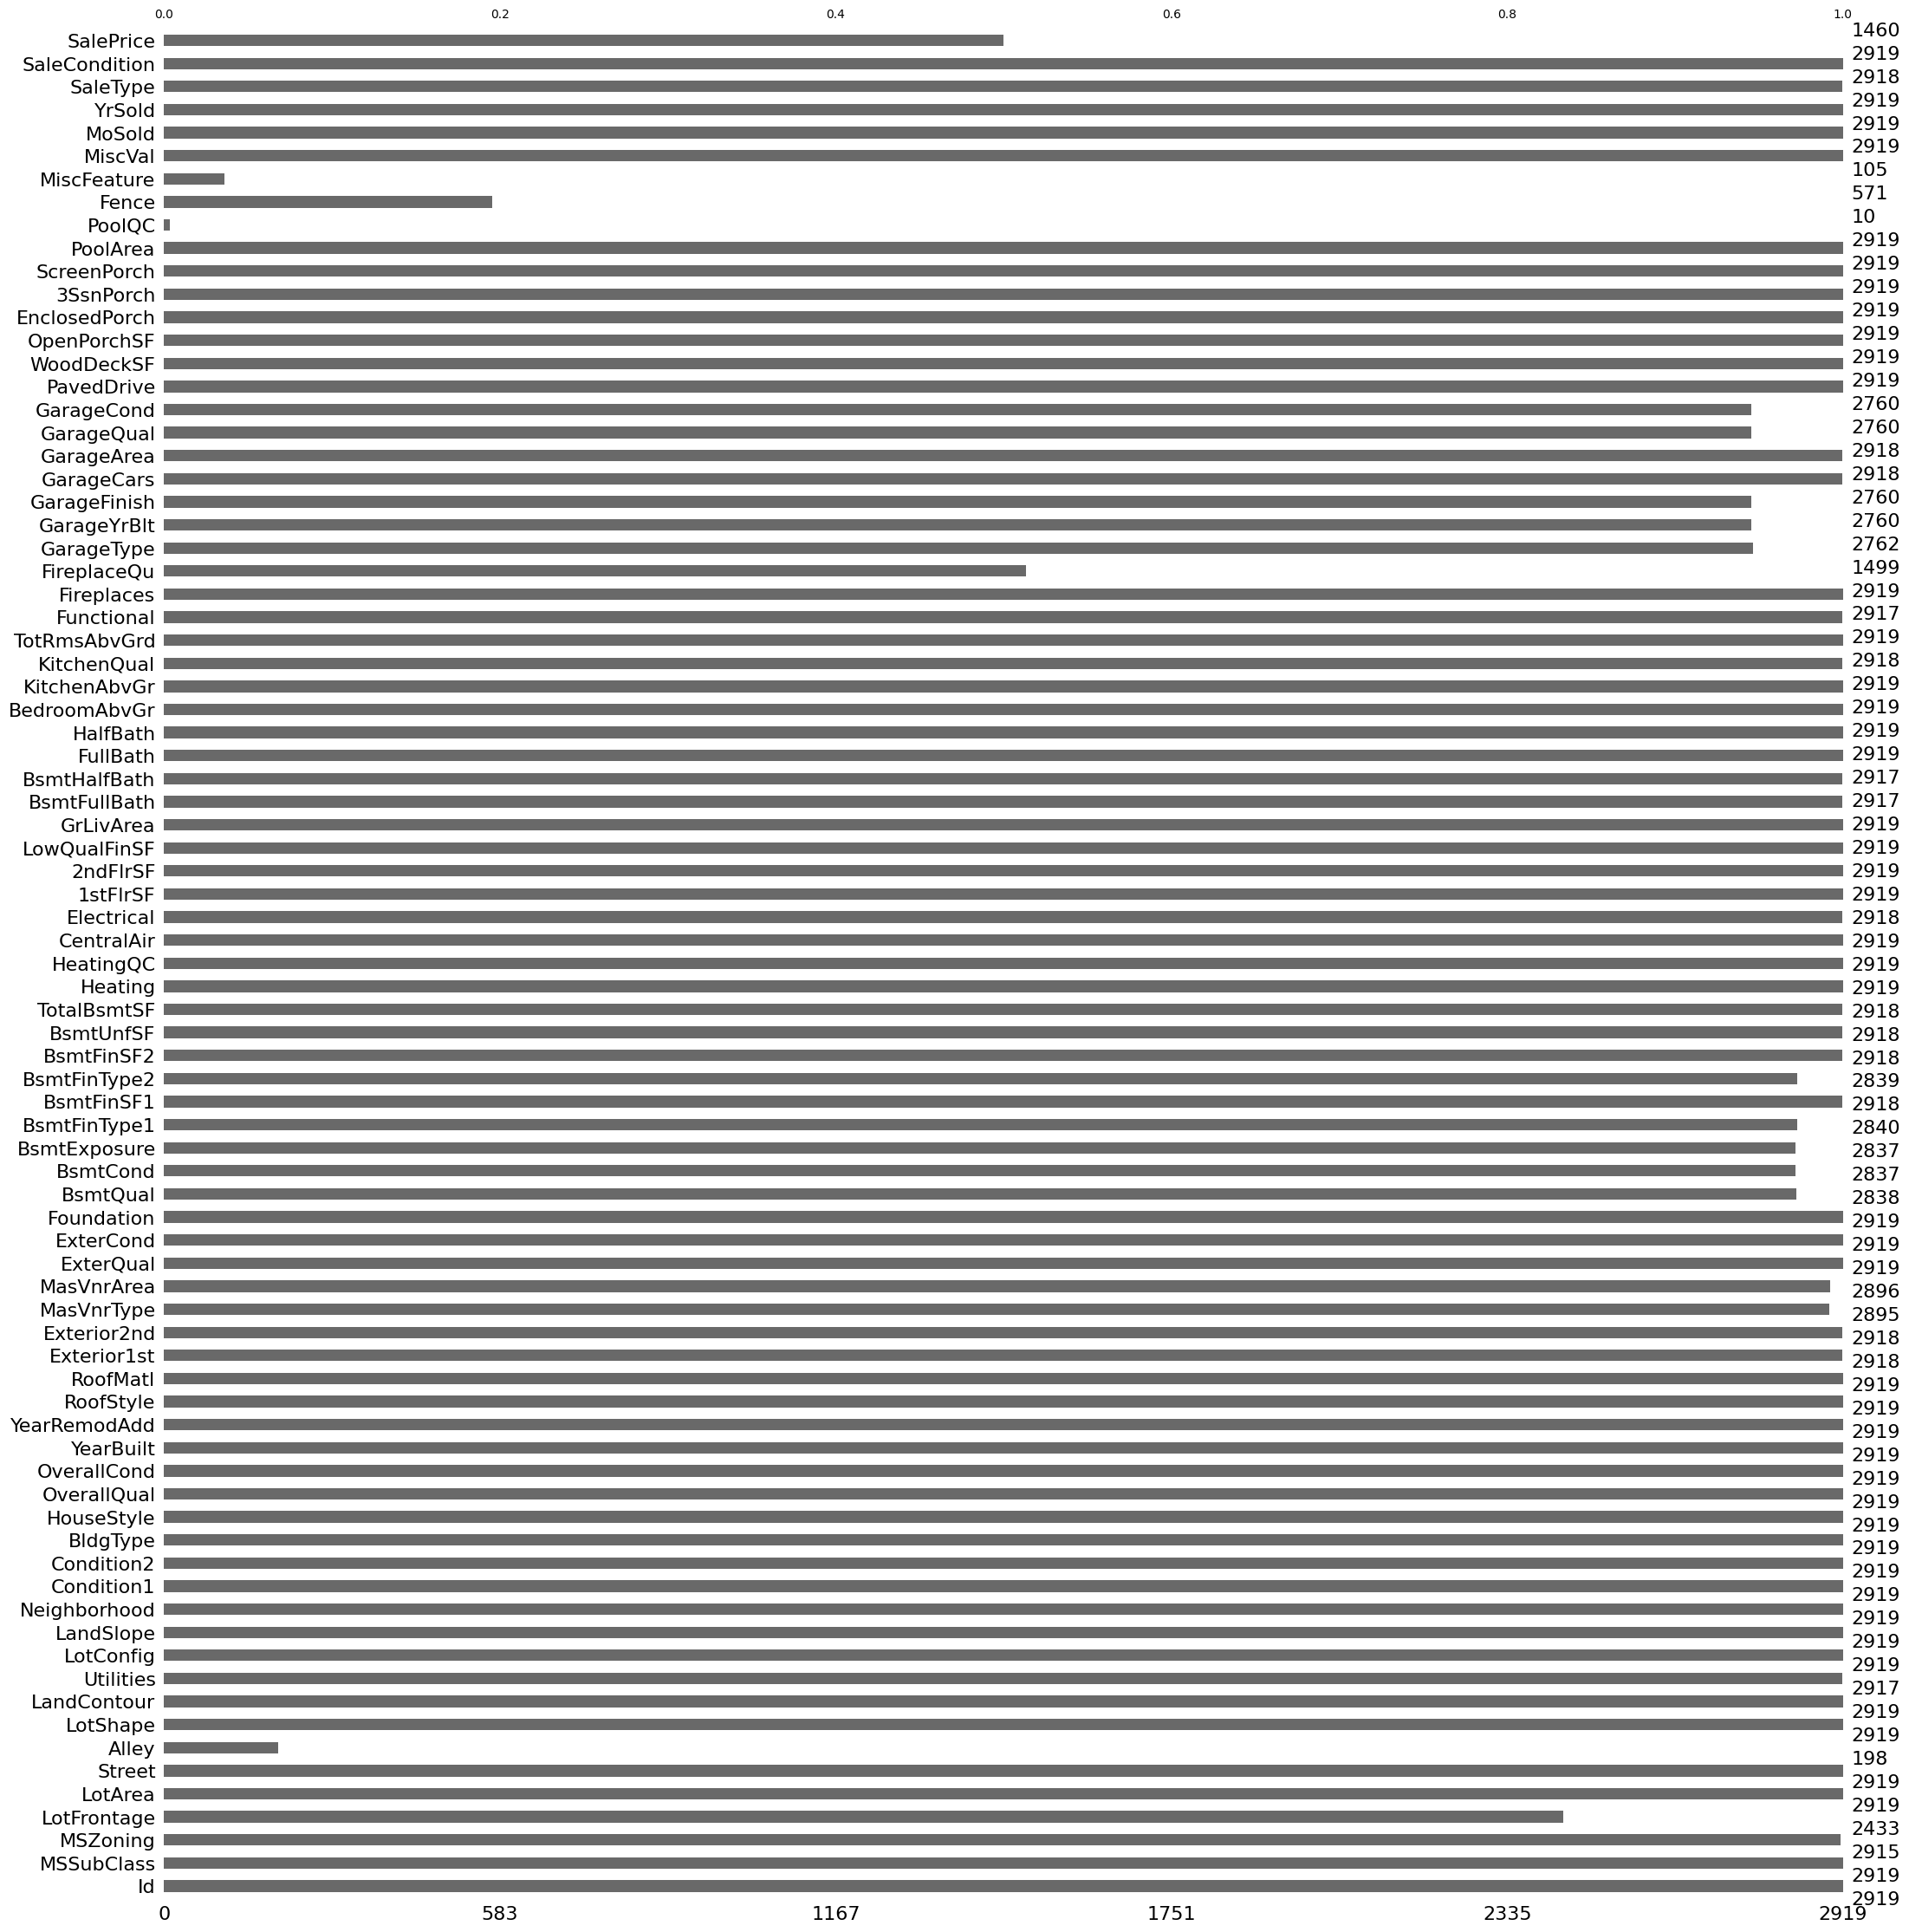

In [ ]:
msno.bar(all_data)

## 欠損値に対する処理 ⇒ dropna()するとかなり行数が減るので今回は残す
- 欠損値のまま取り扱う：「何らかの理由で欠損している」という情報を残す。欠損値を扱えないライブラリを利用する場合には、-9999党のあり得ない値を入れたりする
- 代表値で埋める
  - 平均値
  - 中央値
  - 対数変換などにより歪みの少ない分布にしてから平均をとる
  - グループごとの平均値をとり、その値を入力する
  - Bayesian average
  - 欠損値を目的変数として予測し、予測した値を入力する

## 分布の確認

#### Target の確認(Dependent, Nominal)
- paveの方が分布は広いが，かといってsalepriceに因果関係にあるとは断言しづらい

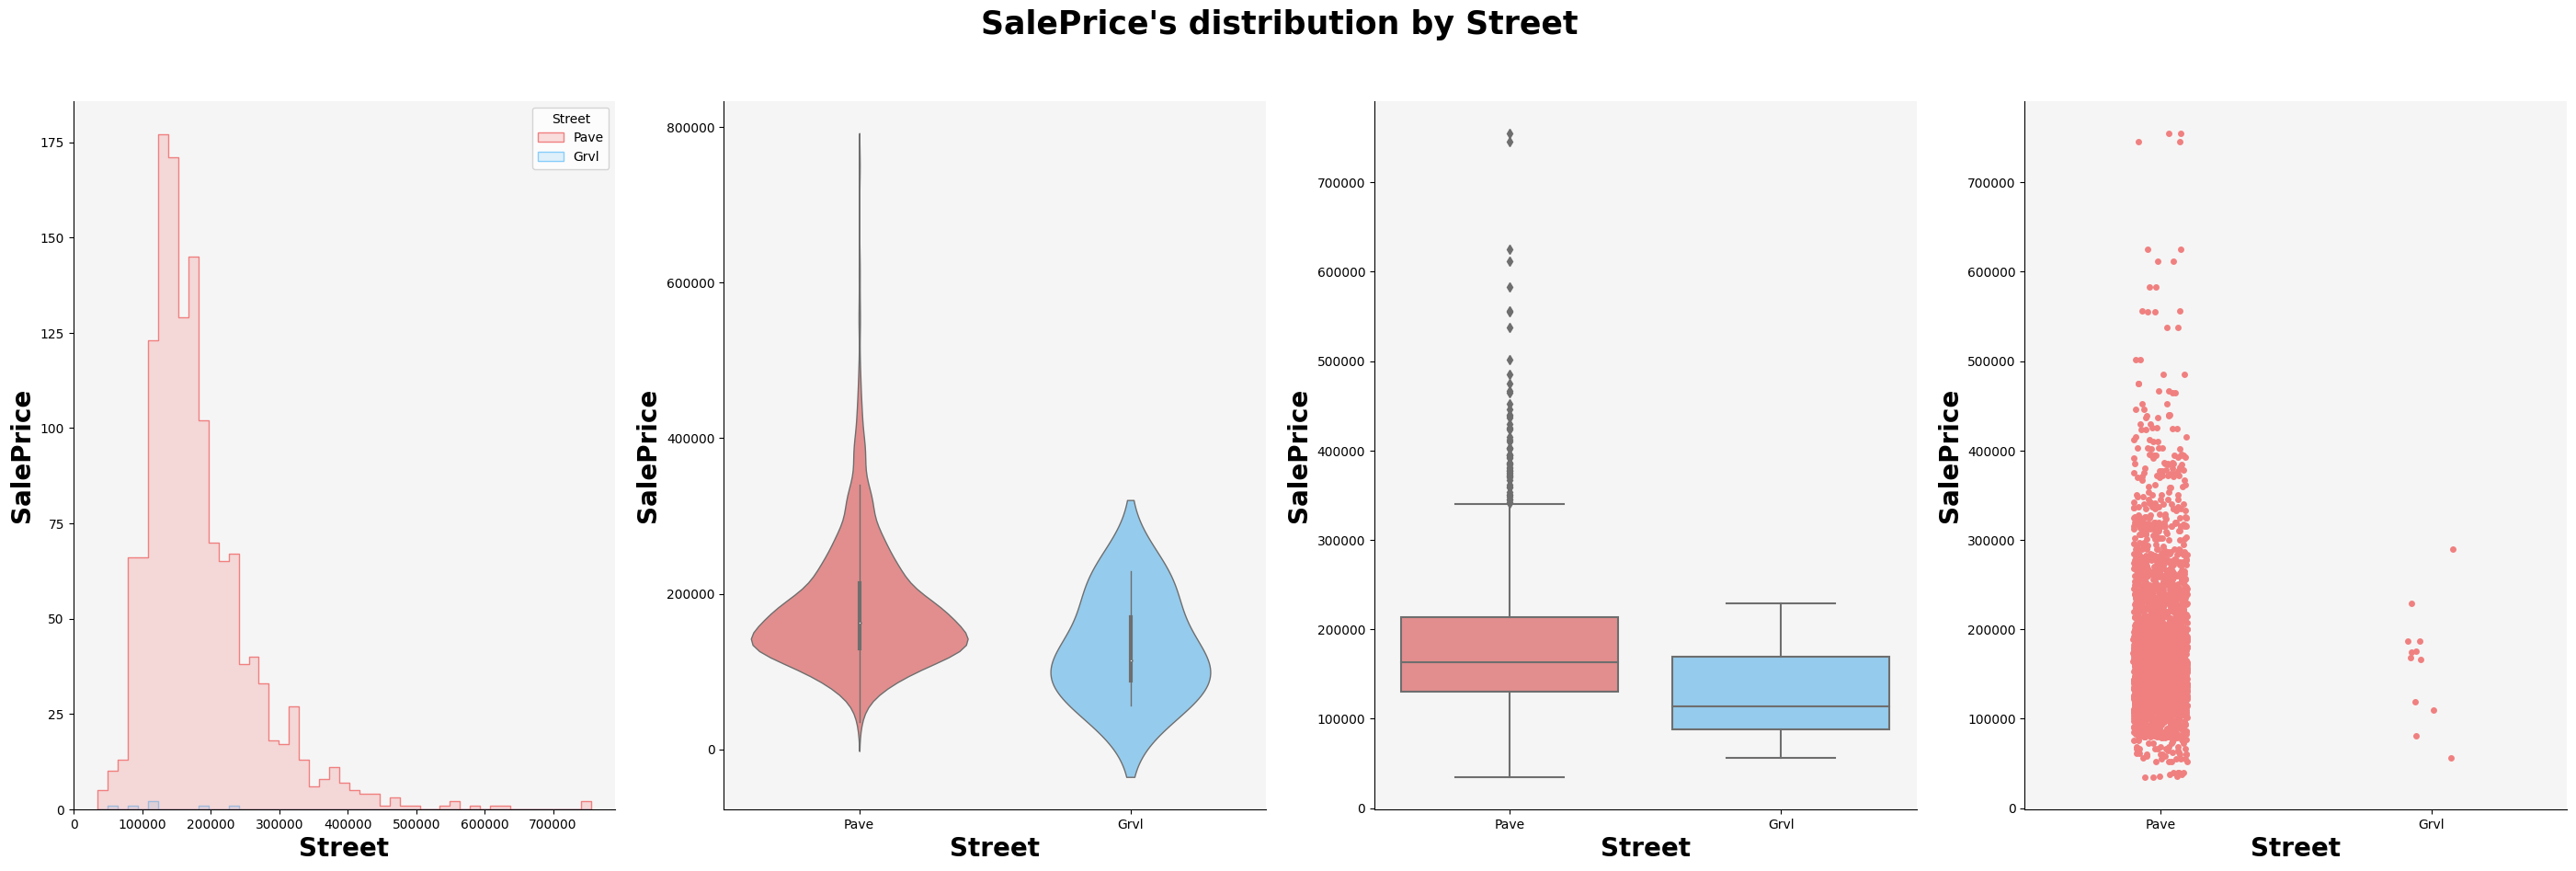

In [ ]:
continuous_dist(all_data, "Street", "SalePrice")

In [ ]:
sns.set()
cols = numerical_cols
sns.pairplot(train[cols], size = 2.5,dropna=True)
plt.show();

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7f2fec499700> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f2fec50c940> (for post_execute):


KeyboardInterrupt: ignored

### 各データの分布（数値）

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>],
       [<Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>],
       [<Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'Kitc

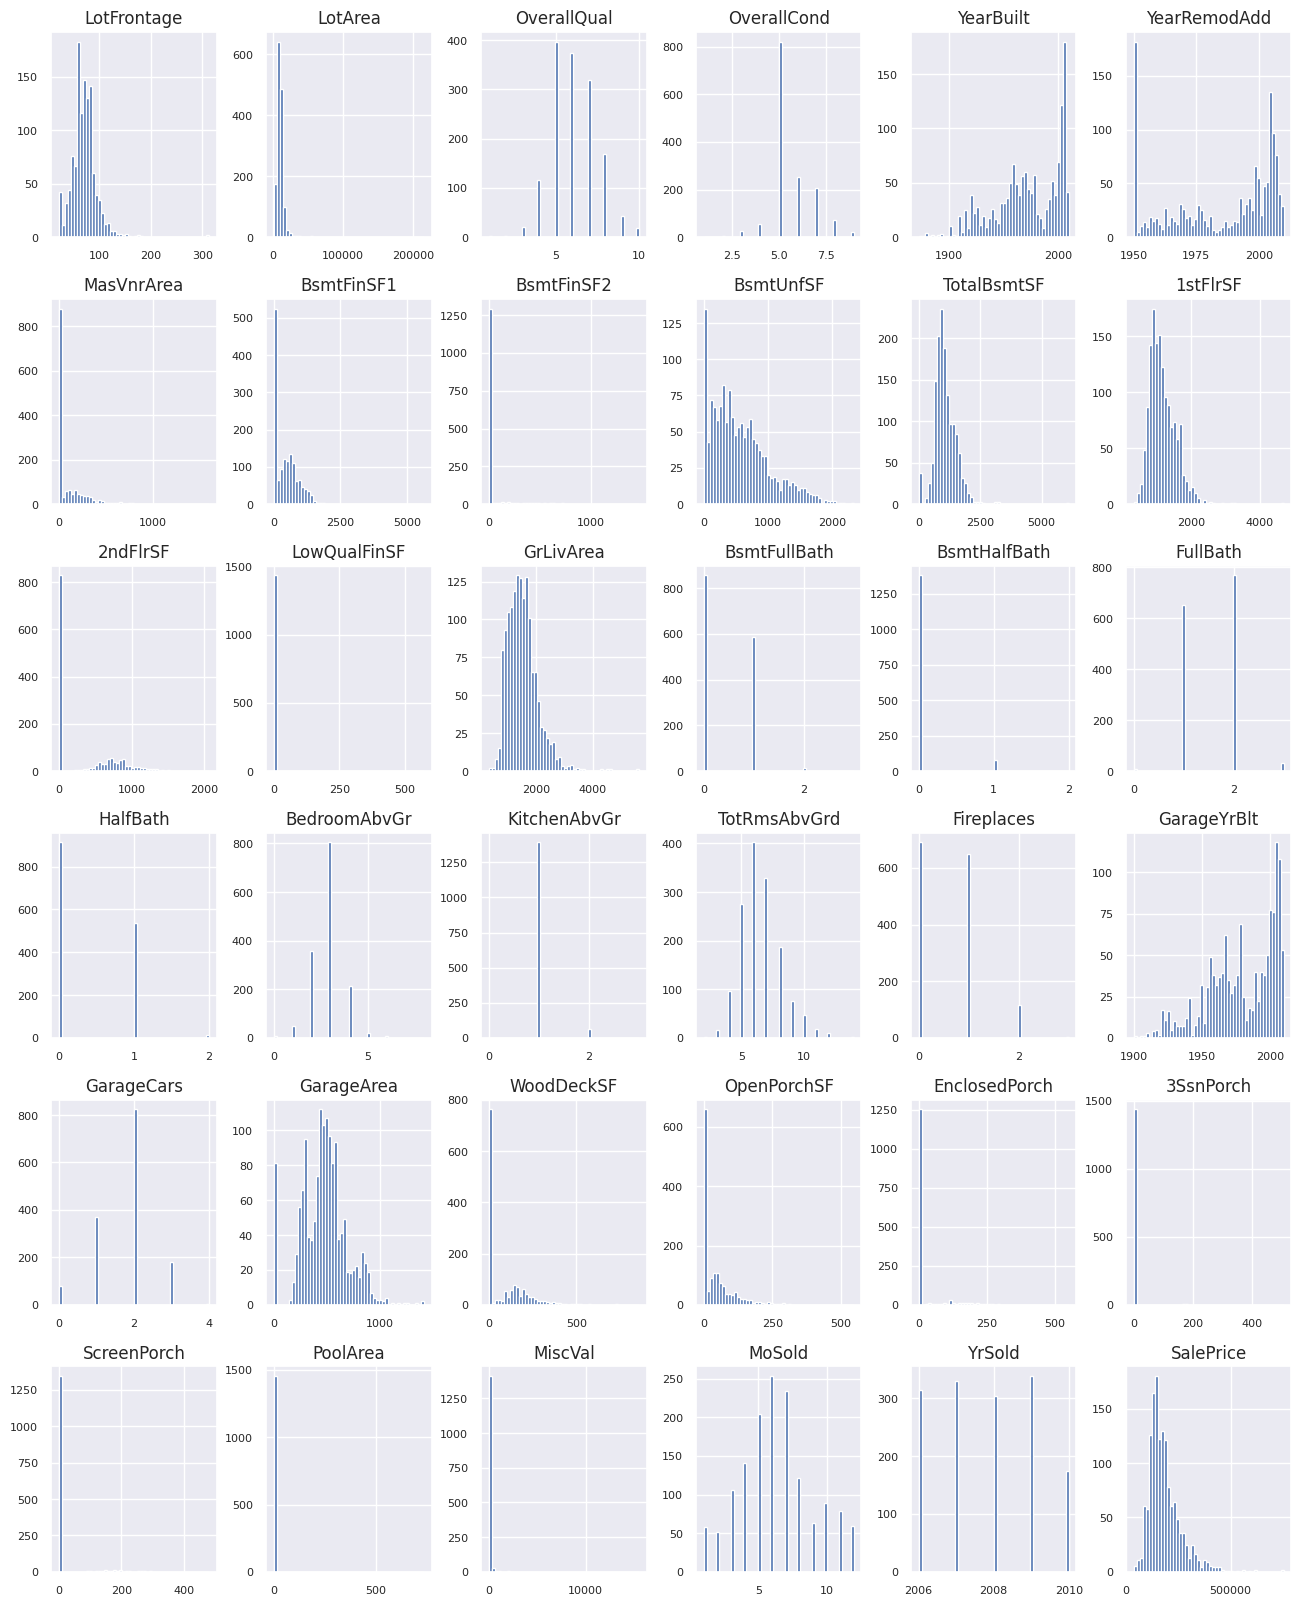

In [ ]:
train[cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

ValueError: ignored

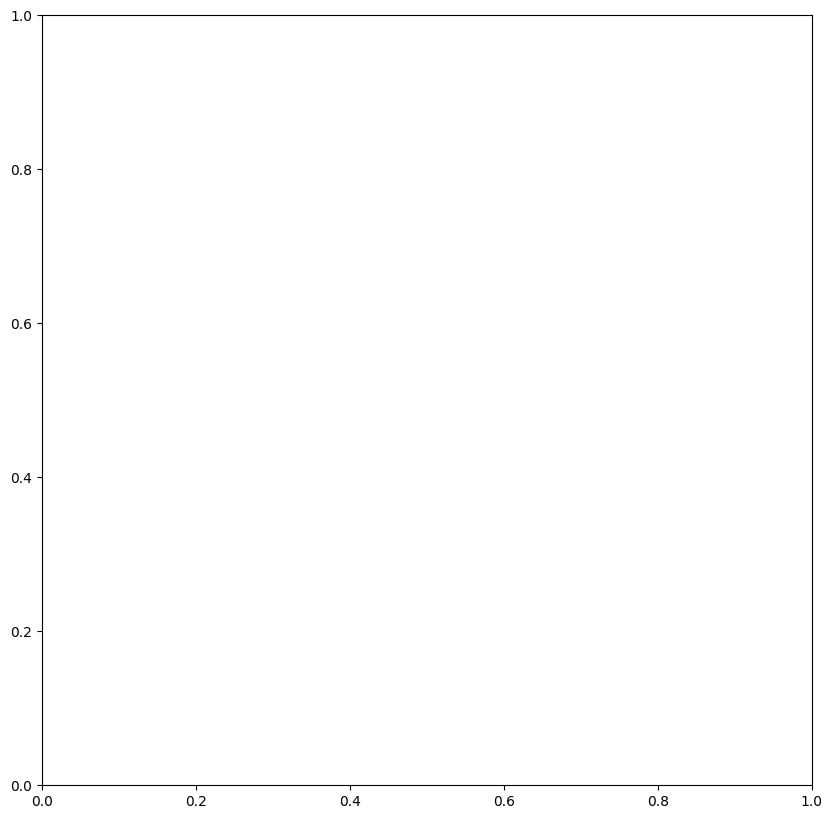

In [ ]:
plt.subplots(figsize=(25, 10))
plt.pie(train.SalePrice.value_counts(), shadow=True, explode=[.03,.03], autopct='%1.1f%%', textprops={'fontsize': 20, 'color': 'white'})
plt.title('SalePrice Distribution', size=20)
plt.legend(['False', 'True'], loc='best', fontsize=12)
plt.show()

### 量的変数

#### Age (Continuous)

In [ ]:
continuous_dist(train, 'Transported', 'Age')
permutation_test(train, 'Transported', 'Age')

#### Age binning

In [ ]:
tmp = train.copy()
tmp['AgeBin'] = 7
for i in range(6):
    tmp.loc[(tmp.Age >= 10*i) & (tmp.Age < 10*(i + 1)), 'AgeBin'] = i
cat_dist(tmp, var='AgeBin', hue='Transported', msg_show=False)

NameError: ignored

#### その他のContinuous

In [ ]:
# logy引数により対数プロットにしている
for col in continuous_vars:
  all_data[col].plot(kind='hist', logy=True)
  plt.xlabel(col)
  plt.ylabel("Frequency")
  plt.show()

In [ ]:
sns.set()
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', "CryoSleep"]
sns.pairplot(train[cols], hue="CryoSleep", size = 2.5,dropna=True)
plt.show();

NameError: ignored

### カテゴリ変数

#### HomePlanet (Nominal)

In [ ]:
# unique が多すぎる変数に対して実行すると busy になってしまうので注意
cat_dist(train, var='HomePlanet', hue='Transported')
display(train.pivot_table(index="HomePlanet", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
anova_perm(train, "HomePlanet", "Transported", logx=False) # 群が3つ以上なので、ANOVAを利用する

#### Destination (Nominal)

In [ ]:
# unique が多すぎる変数に対して実行すると busy になってしまうので注意
cat_dist(train, var='Destination', hue='Transported')
display(train.pivot_table(index="Destination", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
anova_perm(train, "Destination", "Transported", logx=False) # 群が3つ以上なので、ANOVAを利用する

#### Cabin

In [ ]:
tmp = train.copy()
tmp['Deck'] = train.Cabin.apply(lambda x:str(x)[:1])
tmp['side'] = train.Cabin.apply(lambda x:str(x)[-1:])

#### Deck (Nominal)

In [ ]:
cat_dist(tmp, var='Deck', hue='Transported')
display(tmp.pivot_table(index="Deck", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
anova_perm(tmp, "Deck", "Transported", logx=False) # 群が3つ以上なので、ANOVAを利用する

NameError: ignored

#### Side (Nominal, Binary)

In [ ]:
cat_dist(tmp, var='side', hue='Transported')
display(tmp.pivot_table(index="side", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
permutation_test(tmp, 'side', "Transported")

#### CryoSleep (Nominal, binary)

In [ ]:
cat_dist(train, var='CryoSleep', hue='Transported')
display(train.pivot_table(index="CryoSleep", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
permutation_test(train, 'CryoSleep', "Transported")

#### VIP (Nominal, Binary)

In [ ]:
cat_dist(train, var='VIP', hue='Transported')
display(train.pivot_table(index="VIP", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
permutation_test(train, 'VIP', "Transported")

### Multinomial Explore

#### HomePlanet and CryoSleep

In [ ]:
# Heatmap can visualize continuous values (or binary variables) in categories and categories.
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='HomePlanet', columns='CryoSleep', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by HomePlanet and CryoSleep', weight='bold', size=15)
g.set_xlabel('CryoSleep', weight='bold', size=13)
g.set_ylabel('HomePlanet', weight='bold', size=13)
plt.show()

pd.crosstab([train.CryoSleep, train.Transported], train.HomePlanet,margins=True).style.background_gradient()

#### HomePlanet and Destination

In [ ]:
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='HomePlanet', columns='Destination', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by HomePlanet and Destination', weight='bold', size=15)
g.set_xlabel('Destination', weight='bold', size=13)
g.set_ylabel('HomePlanet', weight='bold', size=13)
plt.show()

pd.crosstab([train.Destination, train.Transported], train.HomePlanet,margins=True).style.background_gradient()

#### CryoSleep and Destination

In [ ]:
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='CryoSleep', columns='Destination', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by CryoSleep and Destination', weight='bold', size=15)
g.set_xlabel('Destination', weight='bold', size=13)
g.set_ylabel('CryoSleep', weight='bold', size=13)
plt.show()

pd.crosstab([train.CryoSleep, train.Transported], train.Destination,margins=True).style.background_gradient()

NameError: ignored

# 分析の方針決め

### 分析前の仮説
- 分析の軸をブレストする
- 方針を決める
- 担当者を決める
- 「確認すること（担当者）」のフォーマットでこのセルにメモをする

# 分析
- 統計検定のコードは、「static_analysys.ipynb」を参照
- 特殊なグラフ化のコードは「visualization_templete.ipynb」を参照

## 確認すること1（担当者）：結果

## 確認すること2（担当者）：結果

### 欠損値への対処
- 消費したお金
  - 仮死状態にあれば、お金は消費していないのでは？
  - 仮死状態にない場合には、属性に応じたそれっぽい値を入れる

In [ ]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

#### TotalSpend

##### CryoSleep＝Trueの場合

In [ ]:
# 仮死状態を選択している場合には、消費金額はゼロ
all_data[all_data['CryoSleep']==True]['TotalSpend'].describe()

In [ ]:
for col in spending_cols:
  all_data.loc[(all_data['CryoSleep']==True) & (all_data[col].isna()), col] = 0
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

##### CryoSleep＝Falseの場合

In [ ]:
# 割とばらつきがある
all_data[all_data['CryoSleep']==False]['TotalSpend'].describe()

In [ ]:
plt.scatter(all_data[all_data['CryoSleep']==False]['Age'], all_data[all_data['CryoSleep']==False]['TotalSpend'])

In [ ]:
# 12歳以下の場合にはTotalSpendは0
for age in np.sort(all_data['Age'].unique()):
  data = all_data[all_data['Age']==age]['TotalSpend']
  print(f"age: {age}, min: {data.min()}, mean: {data.mean()}, max: {data.max()}")

In [ ]:
for col in spending_cols:
  all_data.loc[(all_data['CryoSleep']<13) & (all_data[col].isna()), col] = 0

In [ ]:
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

In [ ]:
all_data.isna().sum()

In [ ]:
all_data.loc[:,['Room']] = all_data.PassengerId.apply(lambda x: x[0:4] )
#Here I want to create handbooks to fill in informations in Cabin, VIP status, HomePlanet and Destination.
guide_VIP=all_data.loc[:,['Room','VIP']].dropna().drop_duplicates('Room')
guide_Cabin=all_data.loc[:,['Room','Cabin']].dropna().drop_duplicates('Room')
guide_HomePlanet=all_data.loc[:,['Room','HomePlanet']].dropna().drop_duplicates('Room')
guide_Destination=all_data.loc[:,['Room','Destination']].dropna().drop_duplicates('Room')
all_data=pd.merge(all_data,guide_Cabin,how="left",on='Room',suffixes=('','_y'))
all_data=pd.merge(all_data,guide_VIP,how="left",on='Room',suffixes=('','_y'))
all_data=pd.merge(all_data,guide_HomePlanet,how="left",on='Room',suffixes=('','_y'))
all_data=pd.merge(all_data,guide_Destination,how="left",on='Room',suffixes=('','_y'))

In [ ]:
all_data.loc[:,['VIP']]=all_data.apply(lambda x: x.VIP_y if pd.isna(x.VIP) else x,axis=1)
all_data.loc[:,['Cabin']]=all_data.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
all_data.loc[:,['HomePlanet']]=all_data.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
all_data.loc[:,['Destination']]=all_data.apply(lambda x:  x.Destination_y if pd.isna(x.Destination) else x,axis=1)

In [ ]:
all_data["FirstName"] = all_data['Name'].str.split(" ",expand=True)[0]
all_data["LastName"] = all_data['Name'].str.split(" ",expand=True)[1]

In [ ]:
all_data["Room_LastName"] = all_data['Room']+"_"+all_data["LastName"]

In [ ]:
guide_CryoSleep=all_data.loc[:,['Room','CryoSleep']].dropna().drop_duplicates('Room')
all_data=pd.merge(all_data,guide_CryoSleep,how="left",on='Room',suffixes=('','_y'))
all_data.loc[:,['CryoSleep']]=all_data.apply(lambda x: x.CryoSleep_y if pd.isna(x.CryoSleep) else x,axis=1)

In [ ]:
all_data.isna().sum()

In [ ]:
all_data.columns

### CryoSleepの欠損値を埋めたい

#### XGboost により欠損値を埋める

In [ ]:
all_data['Deck'] = all_data.Cabin.apply(lambda x:str(x)[:1])
all_data['Side'] = all_data.Cabin.apply(lambda x:str(x)[-1:])

In [ ]:
tmp_all_data = all_data[~(all_data["CryoSleep"].isna())]

In [ ]:
# convert to continuous value
for col in tmp_all_data.columns[tmp_all_data.dtypes == object]:
    if col != 'CryoSleep':
        le = LabelEncoder()
        tmp_all_data[col] = le.fit_transform(tmp_all_data[col])
tmp_all_data['VIP'] = tmp_all_data['VIP'].astype('int')

In [ ]:
feature_fill_CryoSleep = ['HomePlanet', 'Cabin', "Deck", "Side", 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'TotalSpend', 'Room']
target_fill_CryoSleep = 'CryoSleep'
X = pd.DataFrame(tmp_all_data, columns=feature_fill_CryoSleep)
y = pd.Series(tmp_all_data[target_fill_CryoSleep])

In [ ]:
X.head()

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

ImportError: ignored

In [ ]:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

In [ ]:
# fit model
bst.fit(X_train, y_train)
# make predictions
y_pred = bst.predict(X_test)

In [ ]:
pd.Series(y_pred).value_counts()

In [ ]:
cm = confusion_matrix(list(y_test), list(y_pred))

print(cm)

In [ ]:
print(f1_score(list(y_test), list(y_pred)))

In [ ]:
all_data[all_data["CryoSleep"].isna()]["CryoSleep"]

In [ ]:
# convert to continuous value
for col in all_data.columns[all_data.dtypes == object]:
    if col != 'CryoSleep':
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col])
all_data['VIP'] = all_data['VIP'].astype('int')

In [ ]:
X_fill_CryoSleep = pd.DataFrame(all_data[all_data["CryoSleep"].isna()], columns=feature_fill_CryoSleep)

In [ ]:
y_fill_CryoSleep = bst.predict(X_fill_CryoSleep)

In [ ]:
y_fill_CryoSleep_index = pd.Series(y_fill_CryoSleep, index=all_data[all_data["CryoSleep"].isna()].index)

In [ ]:
all_data.loc[all_data["CryoSleep"].isna(), "CryoSleep"] = y_fill_CryoSleep_index

#### 欠損値を埋めたので、お金関連の欠損値を埋め直す

In [ ]:
for col in spending_cols:
  all_data.loc[(all_data['CryoSleep']==True) & (all_data[col].isna()), col] = 0
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

#### TotalSpendが、4か所欠損値となっているので、適当な値で埋める

In [ ]:
all_data[all_data["TotalSpend"].isna()]

In [ ]:
# 各値について、中央値は０
for age in all_data[all_data["TotalSpend"].isna()]["Age"]:
    for col in spending_cols:
        median = all_data[all_data["Age"]==age][col].median()
        print(f"age: {age}, col: {col}, median: {median}")

In [ ]:
for col in spending_cols:
  all_data.loc[all_data[col].isna(), col] = 0.0

In [ ]:
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

In [ ]:
all_data.isna().sum()

### Ageの欠損値を埋めたい

#### XGboost により欠損値を埋める

In [ ]:
all_data['CryoSleep'] = all_data['CryoSleep'].astype('int')

In [ ]:
tmp_all_data = all_data[~(all_data["Age"].isna())]

In [ ]:
feature_fill_Age = ['HomePlanet', 'Cabin', "Deck", "Side", 'Destination', 'CryoSleep',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'TotalSpend', 'Room']
target_fill_Age = 'Age'
X = pd.DataFrame(tmp_all_data, columns=feature_fill_Age)
y = pd.Series(tmp_all_data[target_fill_Age])

In [ ]:
X.head()

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

In [ ]:
# fit model
xgb_r.fit(X_train, y_train)
# make predictions
y_pred = xgb_r.predict(X_test)

In [ ]:
# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_pred))

In [ ]:
print(rmse)

In [ ]:
all_data[all_data["Age"].isna()]["Age"]

In [ ]:
X_fill_Age = pd.DataFrame(all_data[all_data["Age"].isna()], columns=feature_fill_Age)

In [ ]:
y_fill_Age = xgb_r.predict(X_fill_Age)

In [ ]:
y_fill_Age_index = pd.Series(y_fill_Age, index=all_data[all_data["Age"].isna()].index)

In [ ]:
all_data.loc[all_data["Age"].isna(), "Age"] = y_fill_Age_index

## 学習してみる

In [ ]:
all_data['PctRoomService'] = all_data['RoomService']/all_data['TotalSpend']
all_data['PctFoodCourt'] = all_data['FoodCourt']/all_data['TotalSpend']
all_data['PctShoppingMall'] = all_data['ShoppingMall']/all_data['TotalSpend']
all_data['PctSpa'] = all_data['Spa']/all_data['TotalSpend']
all_data['PctVRDeck'] = all_data['VRDeck']/all_data['TotalSpend']
all_data

In [ ]:
fill_cols = ['PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']
all_data[fill_cols] = all_data[fill_cols].fillna(0)

In [ ]:
all_data.columns

In [ ]:
feature_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'Age',
       'VIP', 'Transported', 'TotalSpend', 'Room', 'Deck', 'Side', 'PctRoomService',
       'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']

In [ ]:
df_ml = all_data[feature_cols]

In [ ]:
df_ml

In [ ]:
train, X_test = all_data.iloc[:train.shape[0]], all_data.iloc[train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

In [ ]:
display(train.shape)
display(X_test.shape)
display(X_train.shape)
display(y_train.shape)

In [ ]:
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

In [ ]:
scores = []

kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(X_train):
  tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
  tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

  model.fit(tr_x, tr_y)
  va_pred = model.predict(va_x)
  score = accuracy_score(va_y, va_pred)
  scores.append(score)
print(np.mean(scores))